In [54]:
import numpy as np 
import re 
from bs4 import BeautifulSoup
import spacy 
import sys
import gzip
sys.path.append('/Users/anis/test_labnbook/math_ner/indicators/model/fr_LabnbookNer-0.0.0')
from components import *
import streamlit as st
import streamlit.components.v1 as components
import typer 
import os
import pysbd
import json 
import re 
import random 
from spacy.tokens import DocBin
import jsonlines
from spacy.tokens import Span
from prodigy.components.db import connect
from prettytable import PrettyTable
import srsly
from prodigy.components.db import connect
from pathlib import Path 
from spacy import displacy
from pysbd.utils import PySBDFactory
from string import punctuation
from spacy.tokens import Doc
from collections import Counter

from configparser import ConfigParser, ExtendedInterpolation
from collections import defaultdict
from itertools import combinations, product
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary
from gensim.matutils import kullback_leibler, hellinger
from gensim.models import ldamodel
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity
from gensim.utils import simple_preprocess
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.matcher import Matcher
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import spacy

# increase display of columns in pandas
pd.set_option('display.max_colwidth', 200)
#Visualization des phrases et des ents 
from spacy.tokenizer import Tokenizer
# sentence_spans = list(doc.sents)
# displacy.render(sentence_spans, style="ent")

# Notes
    * Changer la segmentations dans le script contrib_and_segmentation
    * rajouter pour chaque versions un champ pour les ents
    * Changer l'agrégation dans le script collaboration 
    * revoir le scripte contribution et l'aggrégation 
    * rajouter une sortie d'un deuxiéme indicateurs 
    * calculer nos deux indicators 
    * séparer les ents

# Fait : 
* Nettoyage des LD en appliquant un GABARIT pour formatter le text dans un format uniforme (ex : coller les points aux mots, mettre un espace après une virgule etc.)
* Detection des tableaux, formules et valeurs avec un modèle de machine learning. C'est ce qu'on appelle les entités nommées (ENTS).
* Dans le traitement fait, on considère chaque entités comme un mot.
* On enlève la ponctuation lors du passage de 'DIFF' après on la réintroduit pour la segmentation en phrases.
* On appliques une logique floue pour chaque mission afin de définir les limites niveaux des indicateurs (faible, moyen et fort) voir : 
    - https://codecrucks.com/what-is-fuzzy-membership-function-complete-guide/
    - https://towardsdatascience.com/machine-learning-with-fuzzy-logic-52c85b46bfe4
    - http://www.sustainability.tuc.gr/261.html
*

# Axes d'amélioration :
* Revoir le calcule des mes indicateurs car j'ai quelques valeurs négative pour l'indice de co-écriture
* Réfléchir à une meilleur aggregation de la matrice de contribution pour construire les indicateurs (peut être de nouveau indicateurs)
* Améliorer les performances du modèle ML de detentions des ENTS avec plus d'exemples annotés
* Réfléchir à comment introduire (exclure ?) les équations, valeurs et tableaux des indicateurs
* Améliorer le tokenizer en ignorant par exemple plus de symbole. Il faut aller chercher dans les LD les symboles à ignorer


# New

In [55]:
nlp = spacy.load("/Users/anis/test_labnbook/math_ner/indicators/model/fr_LabnbookNer-0.0.0")
# displacy.render(list(nlp(text).sents), style="ent")

In [56]:
# text = "Visualiser sur ¥¥l'oscilloscope le signal ε(t)¥¥ : § Expliquez la forme de ε(t) par rapport à e(t) et uG(t) La forme de ε(t) est ce que l'on obtient lorsque l'on soustrait uG(t) à e(t). c'est ce qui explique sa forme un peu étrange. Comment mesurer l'erreur statique ε0sur l'oscillosope? Pour mesurer $$ alpha + beta $$ l’erreur statique ε0, on prend mesure la valeur du signal ε(t) lorsqu'il s'est stabilisé (en+l'infini) § Visualisez les signauxε(t) et uM(t): § Quelle est la relation entre les deuxsignaux? ε(t) est proportionne ¥¥l'oscilloscope le signal ε(t)¥¥  au signal ¥¥UM(t) § Augmentez la valeur¥¥ du gain A et observez uM(t)."
text = "l'exemple suivant est la forme Co-edition."
doc = nlp(text)
nlp.remove_pipe('entity_retokenizer')


('entity_retokenizer',
 <function components.set_entity_retokenizer_component(doc)>)

In [4]:
def get_meta(doc) :
    """
    Get the position of entities and punctuation token's mark
    output : {'ENTS':{'label1':[[star,end],[star,end]...],'label2 : [[star,end],[star,end],...]},'PUNCT':[pos1,pos2,...]}
    """
    # output = dict.fromkeys(list(ent.label_ for ent in doc.ents))
    # for label in output.keys(): 
    #     output[label]= []
    #     for ent in doc.ents : 
    #         if ent.label_ == label :
    #             output[label].append([ent.start, ent.end])

    # punct_pos  = []
    # for token in doc :
    #     if token.is_punct :
    #         punct_pos.append([token.i])
    #  #add a key to the dict for punctuation
    # output = {'ENTS': output, 'PUNCT': punct_pos}
    
    segments = []
    tokens = []
    nb_tokens = 0
    start = 0
    # Get the start and end token position of each segment
    for seg in doc.sents :
        for token in seg :
        # tokens = [token.text for token in seg ]
            if not token.is_punct :
                tokens.append(token.text)
                nb_tokens += 1 
        if nb_tokens == 0 :
            segments.append([0, 0]) 
        else :
            end = nb_tokens -1
            segments.append([start, end])        
            start = end + 1
    # 
    output={}
    output['SEGS'] = segments    
    output['NB_SEGS'] = len(segments)
    # # Get the number of tokens 
    # # Get tokens 
    output['TOKS'] = tokens
    output['NB_TOKS'] = nb_tokens
    return output

In [5]:
def custom_tokenizer(nlp):
    prefix_re = re.compile(r'''\w\'\w+''')
    nlp.tokenizer = Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                    token_match=None)
    return nlp

In [6]:

nlp = custom_tokenizer(nlp)

In [72]:
text ="A l'équivalence est d'avoir de l'architecture. S'aimer c'est bien. Celle-ci est de la co-edtion."
text = "l'équivalence de edededed l’équivalence  eded n(OH-)=n(H+) et l'exemple a l'exemple"
[token for token in nlp(text) ]

[l'équivalence,
 de,
 edededed,
 l’,
 équivalence,
  ,
 eded,
 n(OH-)=n(H+,
 ),
 et,
 l'exemple,
 a,
 l'exemple]

In [8]:
#import a json file  'collab.json'
with open('tmp/collab.json') as f:
    data = json.load(f)

In [25]:
import seaborn as sns 

<AxesSubplot:>

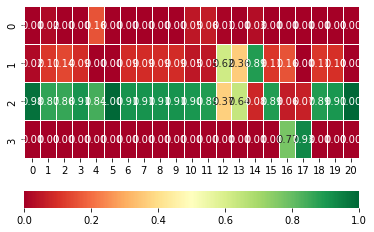

In [42]:
matrix = np.array(data['1694']['47242']['471651']['8363783'][3])
sns.heatmap(matrix, annot=True, fmt='.2f', linewidths=1, cmap='RdYlGn',cbar_kws={"orientation": "horizontal"})

In [43]:
import numpy as np 
import pandas as pd


index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
cols = ['A', 'B', 'C', 'D']
df = pd.DataFrame(abs(np.random.randn(5, 4)), index=index, columns=cols)
df.style.background_gradient(cmap='Blues')


,A,B,C,D
aaa,0.481878,1.211476,1.377530,0.140697
bbb,0.303457,1.269428,0.547275,0.152905
ccc,1.909268,1.032210,1.005568,0.483167
ddd,2.760851,0.090921,0.028296,0.122439
eee,0.284565,0.588188,0.348313,0.390225


In [19]:
from pathlib import Path
import json 
import csv
import pandas as pd
import skfuzzy as fuzz
import numpy as np
from skfuzzy import control as ctrl
import gzip 


In [48]:
results = pd.read_csv('tmp/summary.csv',index_col=0)

In [49]:
def fuzzy_classify(DataFrame ,colnames : list ):
    """Classify a dataframe with fuzzy rules"""
    for colname in colnames:
        nb_report,_ = np.shape(DataFrame)

        if nb_report > 1:
            data = DataFrame[colname]
            min = np.round(data.min(),2)
            max = np.round(data.max(),2)
            mid = np.median(np.arange(min, max, 0.1))
            universe = np.arange(np.floor(min), np.ceil(max)+0.2, 0.1)
            
            trimf_low  = np.round(fuzz.trimf(universe, [min, min, mid]),2)
            trimf_mid = np.round(fuzz.trimf(universe, [min, mid, max+0.1]),2)
            trimf_hi  =  np.round(fuzz.trimf(universe, [mid, max+0.1, max+0.1]),2)
            DataFrame[colname+'_low'] = np.round(fuzz.interp_membership(universe, trimf_low, data),2)
            DataFrame[colname+'_mid'] = np.round(fuzz.interp_membership(universe, trimf_mid, data),2)
            DataFrame[colname+'_high'] = np.round(fuzz.interp_membership(universe, trimf_hi, data),2)
            
            DataFrame[colname+'_membership'] = DataFrame.loc[:, [colname+'_low', colname+'_mid', colname+'_high']].idxmax(axis = 1)
            DataFrame[colname+'_degree'] = DataFrame.loc[:, [colname+'_low', colname+'_mid', colname+'_high']].max(axis = 1)
    return DataFrame 

In [51]:
out = pd.DataFrame()
for id_mission in results['id_mission'].unique(): 
    # Get lines of the mission
    DataFrame = results.loc[results['id_mission'] == id_mission,:]
    fuzzy_classify(DataFrame,['eqc','coec'])
    out = pd.concat([out,DataFrame],axis = 0)

/var/folders/qz/t1vzp79913l2sfbf0b3d9sdr0000gn/T/ipykernel_53683/4049362444.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame[colname+'_low'] = np.round(fuzz.interp_membership(universe, trimf_low, data),2)
/var/folders/qz/t1vzp79913l2sfbf0b3d9sdr0000gn/T/ipykernel_53683/4049362444.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame[colname+'_mid'] = np.round(fuzz.interp_membership(universe, trimf_mid, data),2)
/var/folders/qz/t1vzp79913l2sfbf0b3d9sdr0000gn/T/ipykernel_53683/404936244

In [47]:
out

,id_mission,id_report,id_labdoc,id_trace,n_users,n_tokens,n_segments,eqc,coec,eqc_low,eqc_mid,eqc_high,eqc_membership,eqc_degree,coec_low,coec_mid,coec_high,coec_membership,coec_degree
0,1768,48951,488575,8472128,2,27,1,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1694,47089,473857,8365205,2,85,2,0.00,0.00,1.00,0.00,0.00,eqc_low,1.00,1.00,0.00,0.00,coec_low,1.00
2,1694,47089,473871,8367765,2,72,4,0.30,0.30,0.33,0.67,0.00,eqc_mid,0.67,0.33,0.67,0.00,coec_mid,0.67
3,1694,47089,473885,8365126,2,74,3,0.00,0.00,1.00,0.00,0.00,eqc_low,1.00,1.00,0.00,0.00,coec_low,1.00
4,1694,47089,473879,8365212,3,41,1,0.49,0.49,0.01,0.92,0.07,eqc_mid,0.92,0.01,0.91,0.08,coec_mid,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,1694,47369,472047,8243641,2,163,13,0.18,0.05,0.60,0.40,0.00,eqc_low,0.60,0.89,0.11,0.00,coec_low,0.89
483,1694,47369,472024,8346948,3,988,67,0.45,0.19,0.06,0.90,0.04,eqc_mid,0.90,0.58,0.42,0.00,coec_low,0.58
484,1694,47369,473566,8313779,2,95,5,0.70,0.16,0.00,0.60,0.40,eqc_mid,0.60,0.65,0.35,0.00,coec_low,0.65
485,1694,47369,472049,8363052,3,376,28,0.37,0.20,0.18,0.82,0.00,eqc_mid,0.82,0.56,0.44,0.00,coec_low,0.56


In [52]:
nlp 

NameError: name 'nlp' is not defined

In [73]:
data = ((1,0), (0,1), (.3,.7),(.5,.5))
np.mean(data, axis=0)

array([0.45, 0.55])

In [75]:
   file = '/Users/anis/test_labnbook/math_ner/indicators/tmp/collab.json'
   with gzip.open(file) as f:
        data = json.loads(f.read())

    results = []

    id_missions = data.keys()
    # for each mission
    for id_mission in id_missions:
        id_reports = data[id_mission].keys()
        # for each report
        for id_report in id_reports:
            id_labdocs = data[id_mission][id_report].keys()
            # for each labdoc
            for id_labdoc in id_labdocs:
                # for each trace 
                id_traces = list(data[id_mission][id_report][id_labdoc].keys())
                row = data[id_mission][id_report][id_labdoc][id_traces[-1]]

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [94]:
results = pd.read_csv('tmp/summary.csv',index_col=0)

In [103]:
results_fuzzified = pd.DataFrame()
for id_mission in results['id_mission'].unique(): 
    # Get lines of the mission
    DataFrame = results.loc[(results['id_mission'] == id_mission) &  (results['teacher'] == 0) ,:]
    fuzzified = fuzzy_classify(DataFrame,['eqc','coec'])
    results_fuzzified = pd.concat([results_fuzzified,fuzzified],axis = 0)

In [102]:
# select only when teacher == 0 and id_mission == 1
# results_fuzzified = results_fuzzified.loc[(results_fuzzified['teacher'] == 0) & (results_fuzzified['id_mission'] == 1),:]

DataFrame

,id_mission,id_report,id_labdoc,id_trace,n_users,teacher,n_tokens,n_segments,eqc,coec


In [104]:
results_fuzzified

,id_mission,id_report,id_labdoc,id_trace,n_users,teacher,n_tokens,n_segments,eqc,coec
